# Packages

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from covid19model.models.base import BaseModel
from covid19model.data.utils import construct_initN
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.models.time_dependant_parameter_fncs import make_seasonality_function
import csv
from csv import DictReader

# Data

In [35]:
abs_dir = os.getcwd()
rel_dir = '../../data/interim/QALY_model/postponement_non_covid_care/UZG/'
file_name = 'MZG_residence_times.csv'

types_dict = {'APR_MDC_key': str, 'age_group': str, 'stay_type':str}
residence_times = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()
mean_residence_times = residence_times.groupby(by=['APR_MDC_key']).mean()

file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str, 'week_number': int, 'day_number':int}
hospitalization_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
hospitalization_baseline = hospitalization_baseline.groupby(['APR_MDC_key','week_number','day_number']).median()

file_name = 'MZG_Hospitalizations_per_day_before.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_before = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()

file_name = 'MZG_Hospitalizations_per_day_covid.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_covid = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()

file_name ='MZG_Hospitalizations_per_day_baseline.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()

file_name = 'MZG_covid_hospitalizations_per_day.csv'
types_dict = {'APR_MDC_key': str}
covid_hospitalizations_per_day = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0],dtype=types_dict).squeeze()*2
#covid_hospitalizations_per_day -= 4
#covid_hospitalizations_per_day[np.where(covid_hospitalizations_per_day<0)[0]]=0

MDC_dict={}
file_name = 'MDC_dict.csv'
with open(os.path.join(abs_dir,rel_dir,file_name), mode='r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        MDC_dict.update({row[0]:row[1]})

MDC_keys = hospitalization_baseline.index.get_level_values(0).unique().values
MDC_keys = np.append(MDC_keys,'covid')
MDC_dict.update({'covid':'covid'})
mean_residence_times['covid']=10


# Define model and functions

In [36]:
class postponed_healthcare_model(BaseModel):
    """
    Test model for postponed health_care using a waiting queue before hospitalization
    """
    
    state_names = ['W','H','R','NR']
    parameter_names = ['daily_hospitalizations','X_tot']
    parameters_stratified_names = ['beta','gamma','epsilon','sigma']
    stratification = ['MDC_keys']
    coordinates = [None]
    
    @staticmethod
    def integrate(t, W, H, R, NR, daily_hospitalizations, X_tot, beta, gamma, epsilon, sigma,MDC_keys):
        
        X = (X_tot-sum(H)) * (sigma*W)/sum(sigma*W)

        dW = daily_hospitalizations - 1/beta*np.where(W>X,X,W) - epsilon*W
        dH = (1/beta*np.where(W>X,X,W)) - (1/gamma*H)
        dR = (1/gamma*H)
        dNR = (epsilon*W)
        
        return dW, dH, dR, dNR

In [37]:
def daily_hospitalizations_func(t, states, param,MDC_keys):

    t_string = t.strftime('%Y-%m-%d')
    #if t_string in covid_hospitalizations_per_day.index.get_level_values(0).values:
        #covid_H = covid_hospitalizations_per_day.loc[t_string]
    #else:
        #covid_H=0
    if t >=pd.Timestamp('2020-01-01'):
        covid_H=covid_hospitalizations_per_day.loc[t_string]
    else:
        covid_H=0

    #week = t.isocalendar().week
    #day = t.isocalendar().weekday
    #daily_hospitalizations = hospitalizations_per_day_baseline.loc[MDC_keys[np.where(MDC_keys!='covid')],week,day].values
    #daily_hospitalizations = np.insert(daily_hospitalizations,np.where(MDC_keys=='covid')[0],covid_H)
    
    if t < pd.Timestamp('2020-01-01'):
        daily_hospitalizations = hospitalizations_per_day_before.loc[(MDC_keys[np.where(MDC_keys!='covid')],t_string)].values
    else:
        daily_hospitalizations = hospitalizations_per_day_covid.loc[(MDC_keys[np.where(MDC_keys!='covid')],t_string)].values
    daily_hospitalizations = np.insert(daily_hospitalizations,np.where(MDC_keys=='covid')[0],covid_H)
    return daily_hospitalizations

In [38]:
def hypothetical_covid_peak(t, states, param,MDC_keys,start_peak,end_peak,peak_amplitude):
    start_peak = pd.to_datetime(start_peak)
    end_peak = pd.to_datetime(end_peak)
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    if t <= start_peak:
        covid_H = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    else:
        covid_H=0

    param[np.where(MDC_keys=='covid')]=covid_H
    return param


# Conceptual example

## Parameters

In [39]:
#set start and end date of sim
start_date = pd.to_datetime('2020-06-01')
end_date = pd.to_datetime('2021-06-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = np.array(['03','04','05','covid'])

# Define model parameters, initial states and coordinates
beta = np.ones(len(MDC_classes))*0.1
gamma = mean_residence_times.loc[MDC_classes].values
epsilon = np.ones(len(MDC_classes))*0.01
sigma = np.ones(len(MDC_classes))*1
sigma[np.where(MDC_classes=='covid')]=3

#X_tot = 1049
X_tot = 200
X_init = np.ones(len(MDC_classes))*X_tot/len(MDC_classes)
X_min = 5

daily_hospitalizations = np.array([5,10,20,0])
params={'daily_hospitalizations':daily_hospitalizations, 'X_tot':X_tot,'beta':beta, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma, 'MDC_keys':MDC_classes}

# parameters that control the covid peak
start_peak = '2021-01-01'
end_peak = '2021-03-01'
peak_amplitude = 10
params.update({'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude})


## Initialize model

In [40]:
#start_string = start_date.strftime('%Y-%m-%d')
#W_init = hospitalizations_per_day_covid.loc[(MDC_classes[np.where(MDC_classes!='covid')],start_string)].values
#W_init = np.insert(W_init,np.where(MDC_classes=='covid')[0],0)

W_init = np.ones(len(MDC_classes))*0.001
H_init = np.array([30,50,90,0])

init_states = {'H':H_init,'W':W_init}
coordinates=[MDC_classes,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'daily_hospitalizations': hypothetical_covid_peak})

## Simulate model

In [41]:
model.parameters.update({'peak_amplitude':0,'epsilon':np.zeros(len(MDC_classes))})
out_without_covid = model.sim(sim_len,start_date=start_date)
model.parameters.update({'peak_amplitude':10,'epsilon':epsilon})
out_with_covid = model.sim(sim_len,start_date=start_date)

## plot results

In [42]:
MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2020-06-01')
plot_end_date = pd.to_datetime('2021-06-01')
time = pd.date_range(plot_start_date,plot_end_date)

X = []
for t in time:
    X.append(((X_tot-out_with_covid.sel(time=t).sum('MDC_keys')['H']) * (sigma*out_with_covid.sel(time=t)['W'])/sum(sigma*out_with_covid.sel(time=t)['W'])).values)
X = np.array(X)

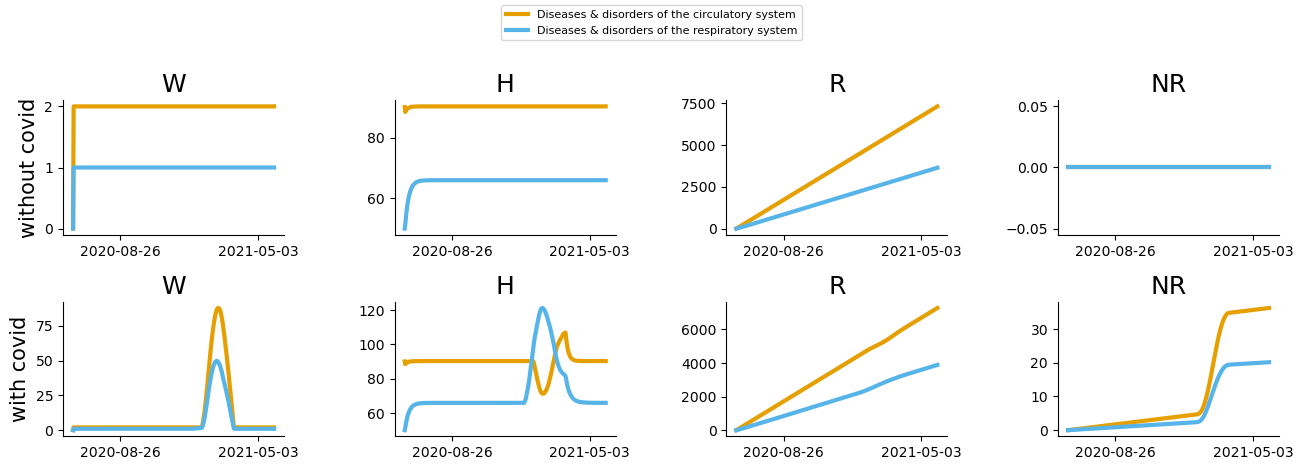

In [43]:
fig, axs = plt.subplots(2,4)
axs = axs.reshape(-1)

label_with = False
label_without = False
idx=0
for with_or_without in ['without','with']:
    out = globals()['out_'+with_or_without+'_covid'].sel(time=time)
    if with_or_without == 'without' and not label_without:
        axs[idx].set_ylabel('without covid')
        label_without=True
    elif with_or_without == 'with' and not label_with:
        axs[idx].set_ylabel('with covid')
        label_with=True
    for state in model.state_names:
        for disease in MDC_plot_classes:
            if disease=='04':
                out_plot = out.sel(MDC_keys=disease)[state]+out.sel(MDC_keys='covid')[state]
            else:
                out_plot = out.sel(MDC_keys=disease)[state]
            axs[idx].plot(time,out_plot, label=MDC_dict[disease])
            axs[idx].set_title(state)
            axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
            axs[idx].grid(False)
            axs[idx].tick_params(axis='both', which='major', labelsize=10)
            axs[idx].tick_params(axis='both', which='minor', labelsize=8)
        idx+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

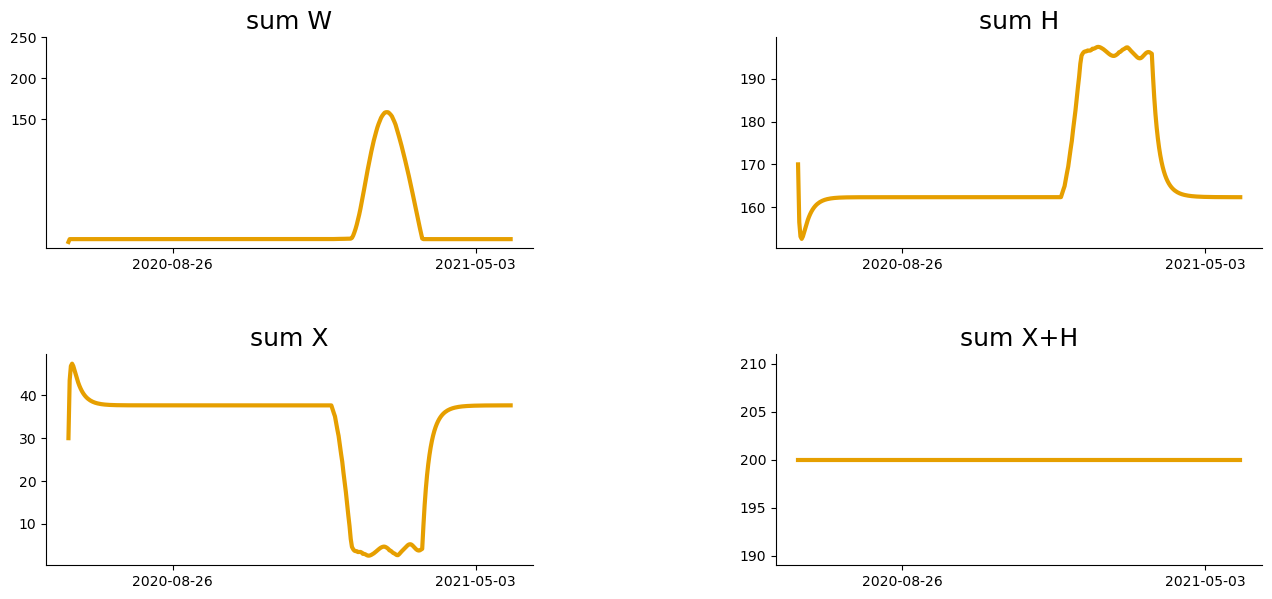

In [44]:
plot_start_date = pd.to_datetime('2020-06-01')
plot_end_date = pd.to_datetime('2021-06-01')
time = pd.date_range(plot_start_date,plot_end_date)
out = out_with_covid.sel(time=time)

fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state=='X':
        out_plot = np.sum(X,axis=1)
    elif state == 'X+H':
        out_plot = np.sum(X,axis=1) + out.sum('MDC_keys')['H']
    else:
        out_plot = out.sum('MDC_keys')[state]
    axs[idx].plot(time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_yticks

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
axs[0].set_yticks(ticks=[X_tot-50,X_tot,X_tot+50])
plt.show()

## Parameter influences 

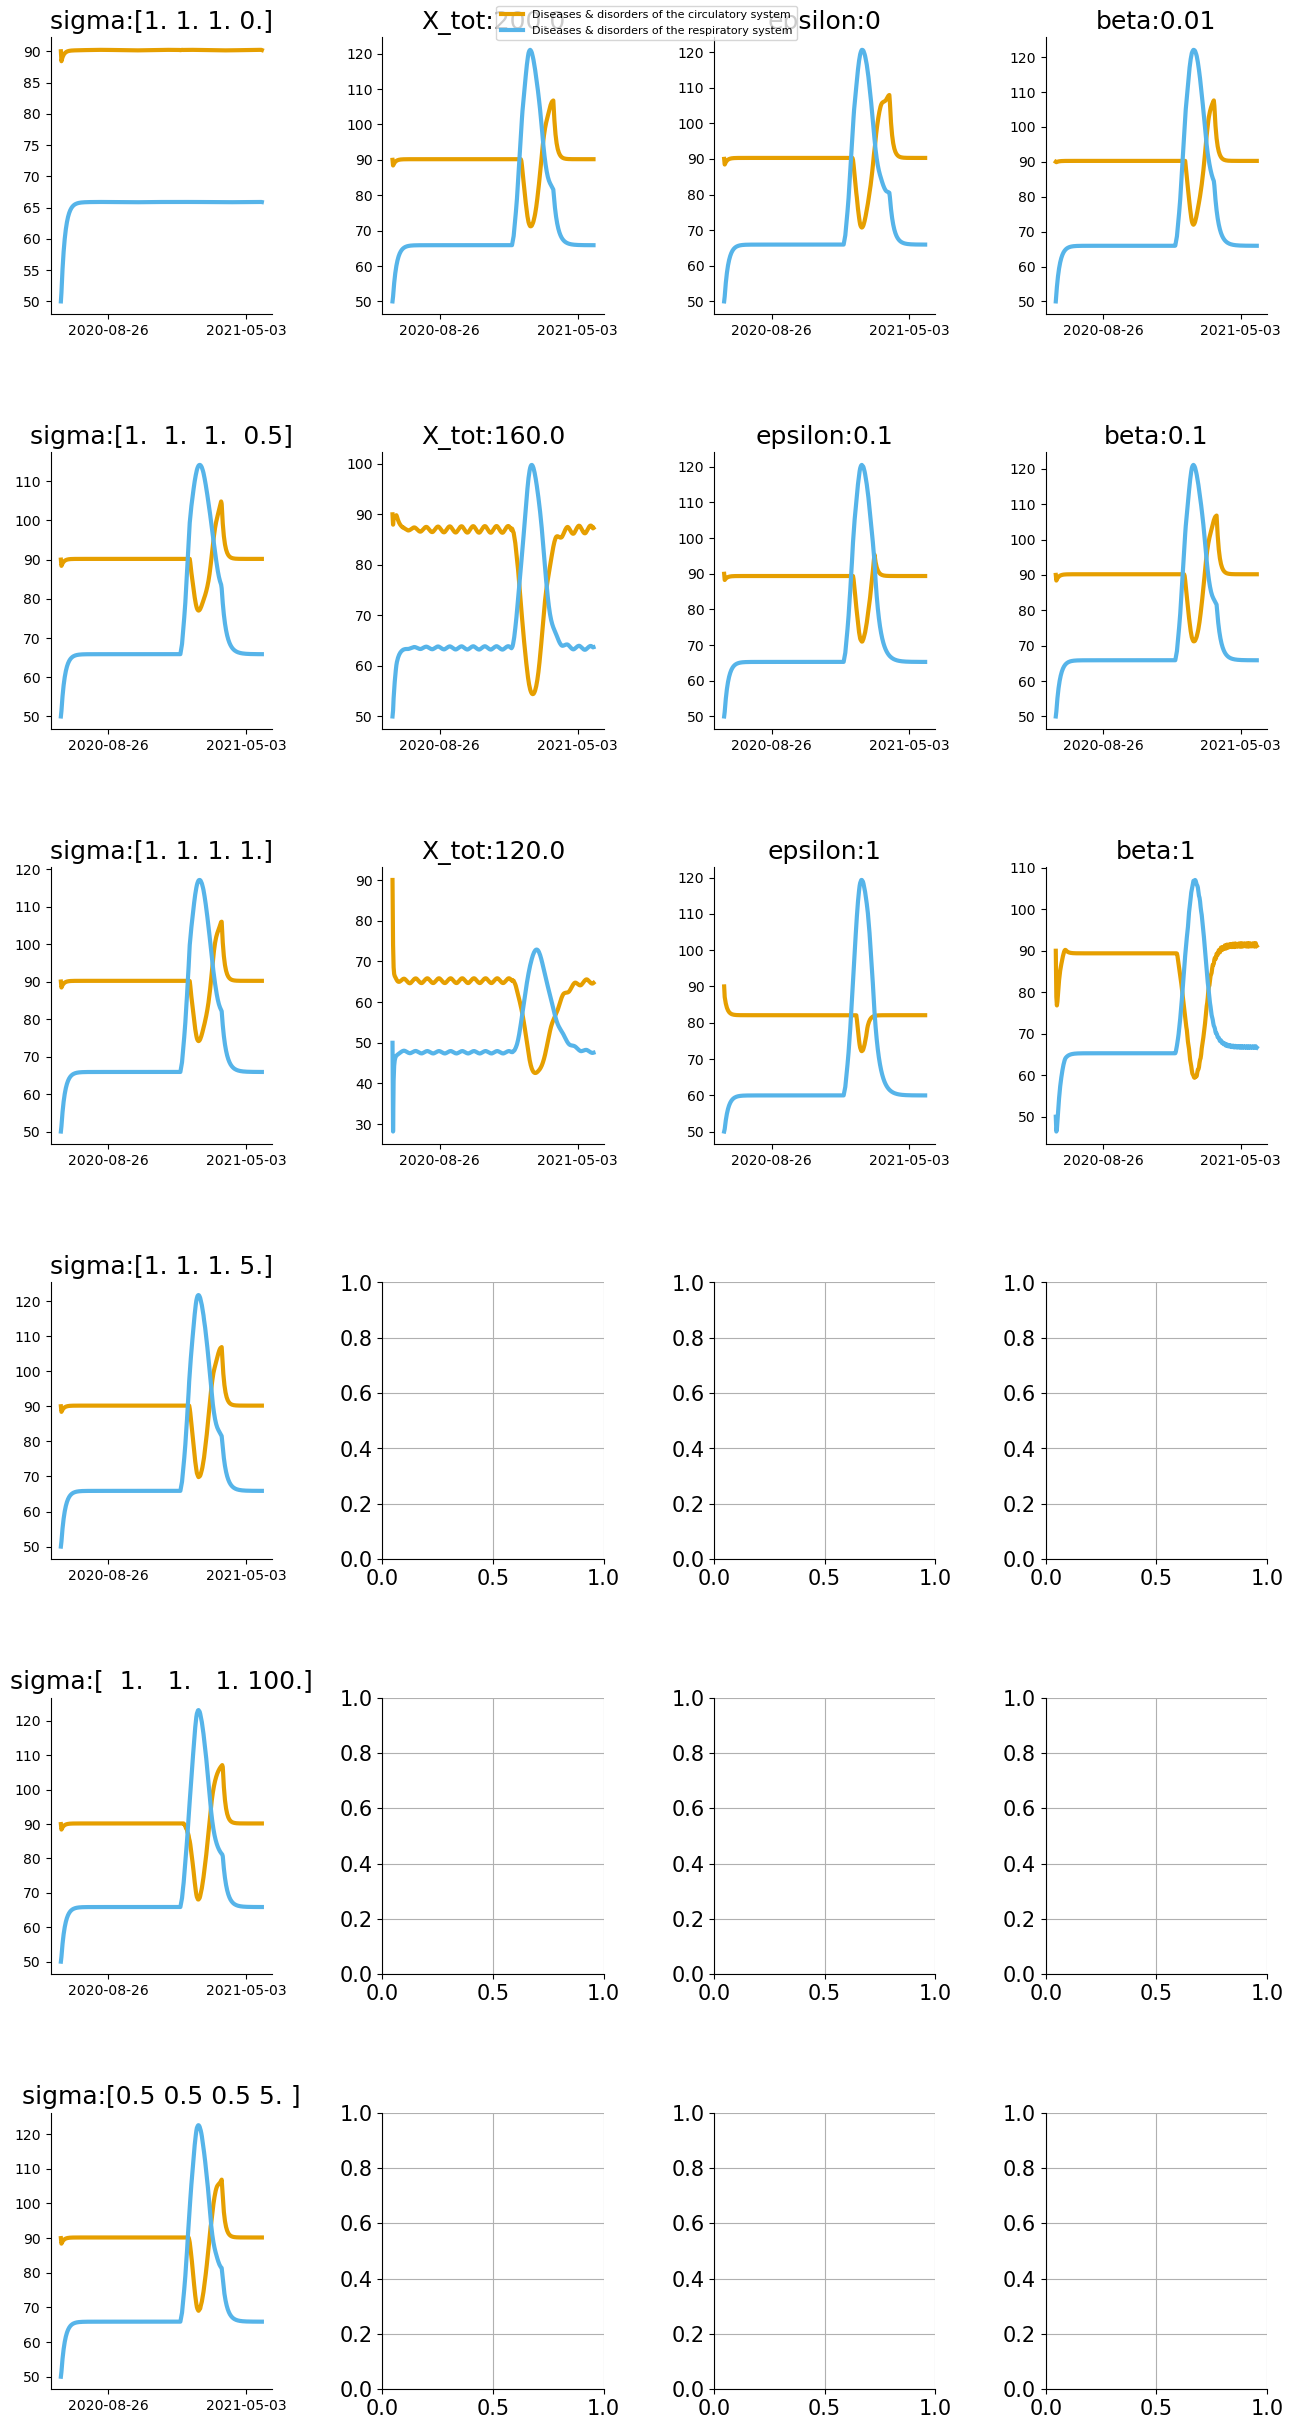

In [45]:
MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2020-06-01')
plot_end_date = pd.to_datetime('2021-06-01')
time = pd.date_range(plot_start_date,plot_end_date)

sigma_covid_choices = [0,0.5,1,5,100]
sigma_choices = []
for i in range(len(sigma_covid_choices)):
    temp = sigma.copy()
    temp[np.where(MDC_classes=='covid')]=sigma_covid_choices[i]
    sigma_choices.append(temp)
temp = sigma.copy()
temp[:]=0.5
temp[np.where(MDC_classes=='covid')]=5
sigma_choices.append(temp)
X_tot_choices = np.array([1,0.8,0.6])*X_tot
epsilon_choices = [0,0.1,1]
beta_choices = [0.01,0.1,1]

parameters = [sigma_choices,X_tot_choices,epsilon_choices,beta_choices]
parameters_string = ['sigma','X_tot','epsilon','beta']
longest = 0
for parameter in parameters:
    if len(parameter)>longest:
        longest=len(parameter)

fig, axs = plt.subplots(longest,len(parameters))
for j,parameter in enumerate(parameters):
    for i in range(len(parameter)):
        model.parameters.update({parameters_string[j]:parameter[i]})
        out = model.sim(sim_len,start_date=start_date)
        for disease in MDC_plot_classes:
            if disease=='04':
                out_plot = out.sel(MDC_keys=disease)['H']+out.sel(MDC_keys='covid')['H']
            else:
                out_plot = out.sel(MDC_keys=disease)['H']
            axs[i,j].plot(time,out_plot, label=MDC_dict[disease])
            axs[i,j].set_title(parameters_string[j]+':'+str(parameter[i]))
            axs[i,j].xaxis.set_major_locator(plt.MaxNLocator(2))
            axs[i,j].grid(False)
            axs[i,j].tick_params(axis='both', which='major', labelsize=10)
            axs[i,j].tick_params(axis='both', which='minor', labelsize=8)
    model.parameters.update({parameters_string[j]:globals()[parameters_string[j]]})

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=5,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[i,j].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

# Fitting real world data

## Before Covid

### Parameters

In [46]:
#set start and end date
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2020-01-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = MDC_keys.copy()

# Define model parameters, initial states and coordinates
beta = np.ones(len(MDC_classes))*0.01
gamma = mean_residence_times.loc[MDC_classes].values
epsilon = np.ones(len(MDC_classes))*0
sigma = np.ones(len(MDC_classes))*1
sigma[np.where(MDC_classes=='covid')]=10

X_tot = 1049
#X_min = 1
daily_hospitalizations = hospitalizations_per_day_before.loc[(MDC_classes,start_date.strftime('%Y-%m-%d'))].values

params={'daily_hospitalizations':daily_hospitalizations, 'X_tot':X_tot,'beta':beta, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma, 'MDC_keys':MDC_classes}

C:\Users\wolfd\AppData\Local\Temp\ipykernel_10044\846426575.py:18: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  daily_hospitalizations = hospitalizations_per_day_before.loc[(MDC_classes,start_date.strftime('%Y-%m-%d'))].values


### Initialize model

In [47]:
H_init = hospitalization_baseline.loc[MDC_classes,start_date.isocalendar().week,start_date.isocalendar().weekday].values
H_init = np.insert(H_init,np.where(MDC_classes=='covid')[0],0)

W_init = np.ones(len(MDC_classes))*0.001
#start_string = start_date.strftime('%Y-%m-%d')
#W_init = hospitalizations_per_day_before.loc[(MDC_classes[np.where(MDC_classes!='covid')],start_string)].values
#W_init = np.insert(W_init,np.where(MDC_classes=='covid')[0],0)
#X_init = H_init + (X_tot-sum(H_init))/len(MDC_classes)

init_states = {'H':H_init,'W':W_init}
coordinates=[MDC_classes,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'daily_hospitalizations': daily_hospitalizations_func})

C:\Users\wolfd\AppData\Local\Temp\ipykernel_10044\1690231532.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  H_init = hospitalization_baseline.loc[MDC_classes,start_date.isocalendar().week,start_date.isocalendar().weekday].values


### simulate model

In [48]:
out_real_world_before = model.sim(sim_len,start_date=start_date)

KeyboardInterrupt: 

### plot results

In [ ]:
MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2018-01-01')
plot_end_date = pd.to_datetime('2020-01-01')
time = pd.date_range(plot_start_date,plot_end_date)
out = out_real_world_before.sel(time=time).copy()

X = []
for t in time:
    X.append(((X_tot-out.sel(time=t).sum('MDC_keys')['H']) * (sigma*out.sel(time=t)['W'])/sum(sigma*out.sel(time=t)['W'])).values)
X = np.array(X)


#### States


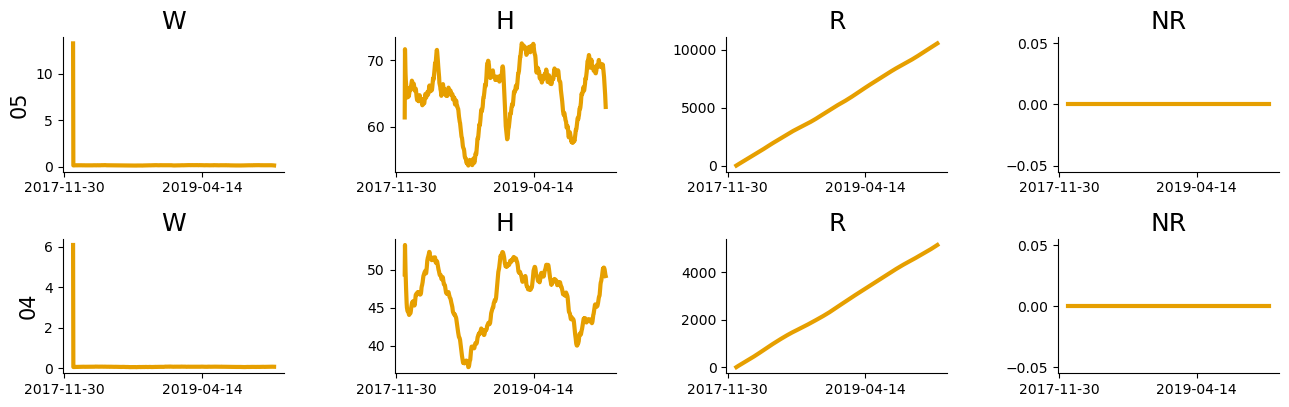

In [ ]:
fig, axs = plt.subplots(len(MDC_plot_classes),4)

for disease_idx, disease in enumerate(MDC_plot_classes):
    axs[disease_idx,0].set_ylabel(disease)
    for state_idx, state in enumerate(model.state_names):
        if disease=='04':
            out_plot = out.sel(MDC_keys=disease)[state]+out.sel(MDC_keys='covid')[state]
        else:
            out_plot = out.sel(MDC_keys=disease)[state].copy()
        axs[disease_idx,state_idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[disease_idx,state_idx].set_title(state)
        axs[disease_idx,state_idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[disease_idx,state_idx].grid(False)
        axs[disease_idx,state_idx].tick_params(axis='both', which='major', labelsize=10)
        axs[disease_idx,state_idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center',fontsize=8)
#plt.legend()
plt.show()

#### X-H

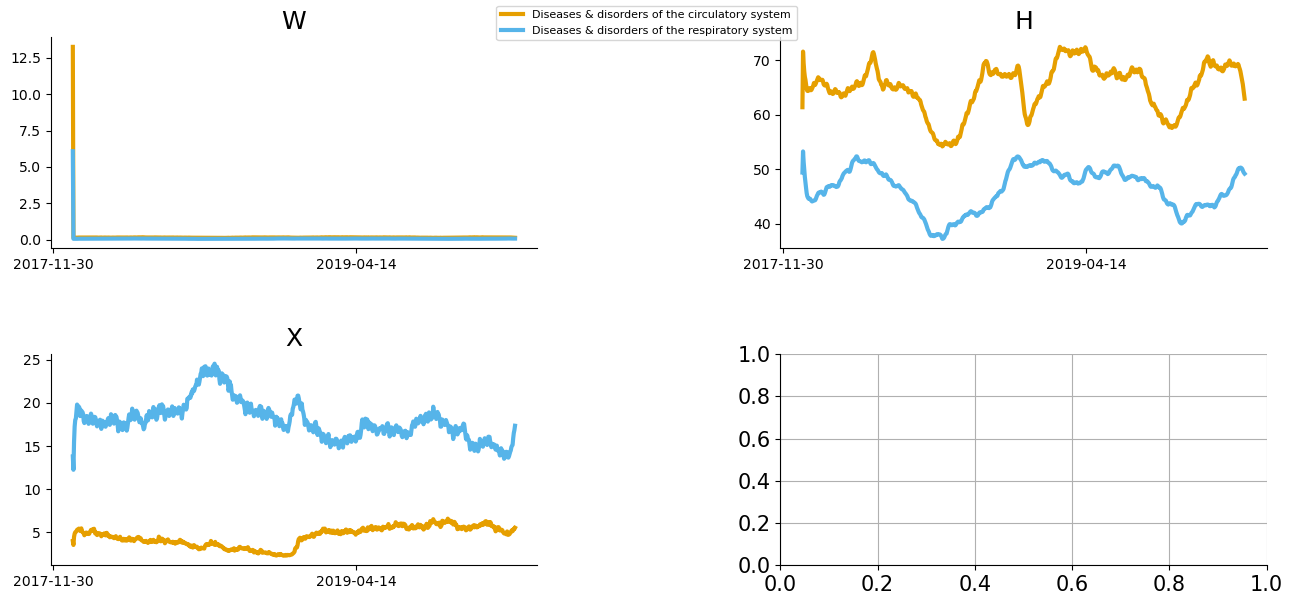

In [ ]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X']):
    for dis_idx, disease in enumerate(MDC_plot_classes):
        if state=='X':
            out_plot = X[:,dis_idx]
        else:
            out_plot = out.sel(MDC_keys=disease)[state].copy()
        axs[idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,fontsize=8,loc='upper center')
plt.show()

#### Sum

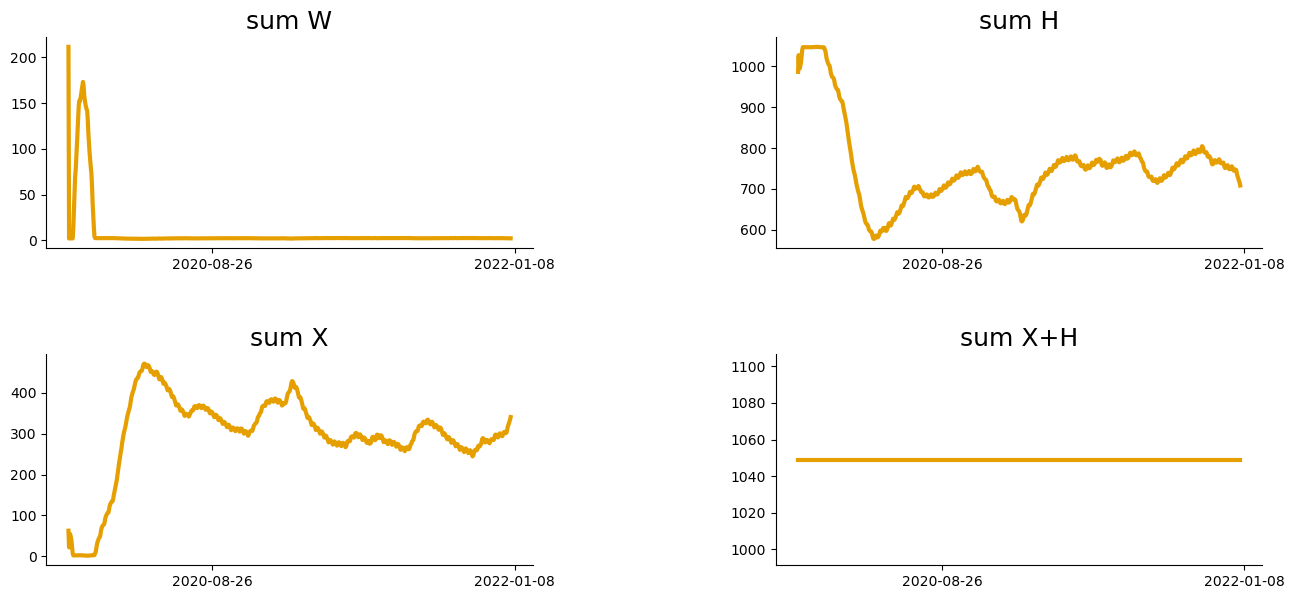

In [ ]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state=='X':
        out_plot = np.sum(X,axis=1)
    elif state == 'X+H':
        out_plot = np.sum(X,axis=1) + out.sum('MDC_keys')['H']
    else:
        out_plot = out.sum('MDC_keys')[state]
    axs[idx].plot(time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
#axs[0].set_yticks(ticks=[X_tot-50,X_tot,X_tot+50])
plt.show()


#### daily_hospitalizations 

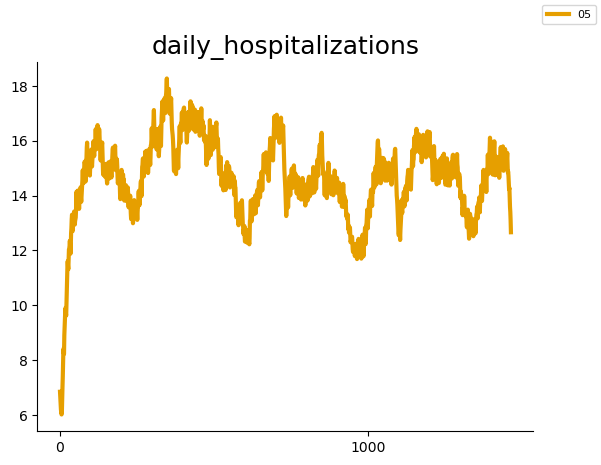

In [ ]:
fig, ax = plt.subplots()
ax.set_title('daily_hospitalizations')
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
for idx,disease in enumerate(['05']):
    ax.plot(range(len(hospitalizations_per_day_before[disease])),hospitalizations_per_day_before[disease], label=disease)
fig.legend(fontsize=8)
plt.show()

#### normalized

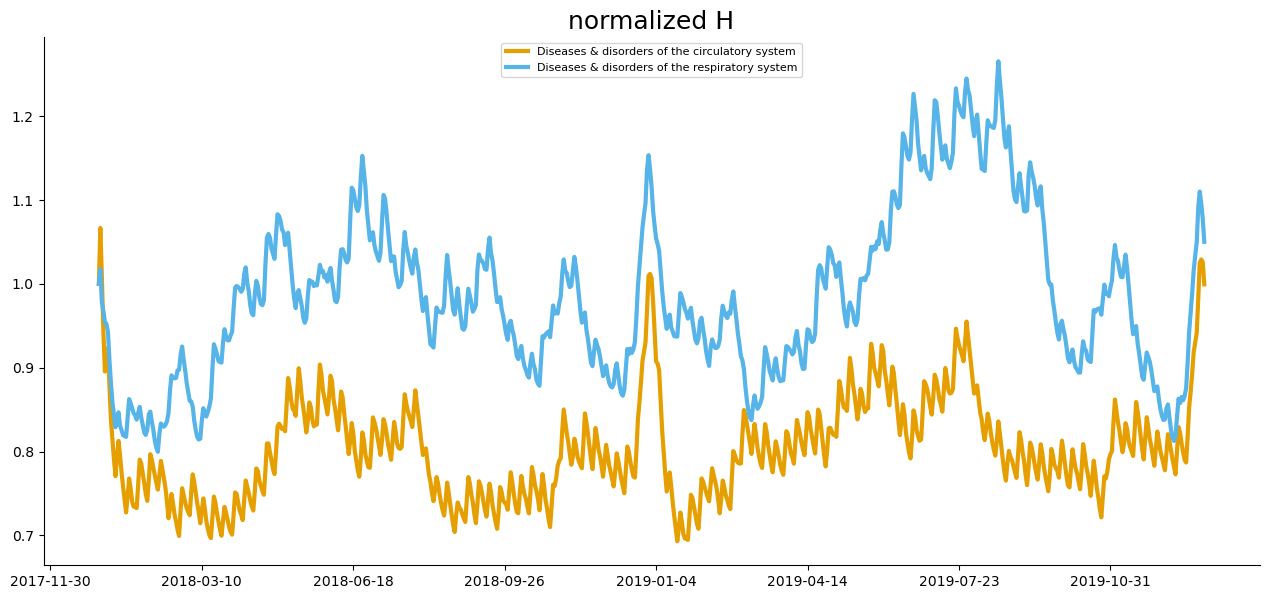

In [ ]:
fix,ax=plt.subplots()

for disease in MDC_plot_classes:
    if disease=='04':
        out_plot = out.sel(MDC_keys=disease)['H']-out.sel(MDC_keys='covid')['H'].values
    else:
        out_plot = out.sel(MDC_keys=disease)['H'].copy().values

    for idx, t in enumerate(time):
        week=t.isocalendar().week
        day=t.isocalendar().weekday
        out_plot[idx] = out_plot[idx]/hospitalization_baseline.loc[disease,week,day]
    out_plot = pd.DataFrame(out_plot).ewm(span=14).mean()
    ax.plot(time,out_plot, label=MDC_dict[disease])
    ax.set_title('normalized H')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

## Covid

### Parameters

In [ ]:
#set start and end date
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2022-01-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = MDC_keys.copy()

# Define model parameters, initial states and coordinates
beta = np.ones(len(MDC_classes))*0.01
gamma = mean_residence_times.loc[MDC_classes].values
epsilon = np.ones(len(MDC_classes))*0.1
sigma = np.ones(len(MDC_classes))*1
sigma[np.where(MDC_classes=='covid')]=10

X_tot = 1049
X_min = 1
daily_hospitalizations = hospitalizations_per_day_covid.loc[(MDC_classes,start_date.strftime('%Y-%m-%d'))].values

params={'daily_hospitalizations':daily_hospitalizations, 'X_tot':X_tot,'beta':beta, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma, 'MDC_keys':MDC_classes}

C:\Users\wolfd\AppData\Local\Temp\ipykernel_26324\1274639414.py:18: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  daily_hospitalizations = hospitalizations_per_day_covid.loc[(MDC_classes,start_date.strftime('%Y-%m-%d'))].values


### Initialize model

In [ ]:
H_init = hospitalization_baseline.loc[MDC_classes,start_date.isocalendar().week,start_date.isocalendar().weekday].values
H_init = np.insert(H_init,np.where(MDC_classes=='covid')[0],0)

#X_init = H_init + (X_tot-sum(H_init))/len(MDC_classes)
#start_string = start_date.strftime('%Y-%m-%d')
#W_init = hospitalizations_per_day_covid.loc[(MDC_classes[np.where(MDC_classes!='covid')],start_string)].values
#W_init = np.insert(W_init,np.where(MDC_classes=='covid')[0],0)
W_init = np.ones(len(MDC_classes))*0.001

init_states = {'H':H_init,'W':W_init}
coordinates=[MDC_classes,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'daily_hospitalizations': daily_hospitalizations_func})

C:\Users\wolfd\AppData\Local\Temp\ipykernel_26324\4085360704.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  H_init = hospitalization_baseline.loc[MDC_classes,start_date.isocalendar().week,start_date.isocalendar().weekday].values


### simulate model

In [ ]:
out_real_world_covid = model.sim(sim_len,start_date=start_date)

### plot results

In [ ]:
MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2020-01-01')
plot_end_date = pd.to_datetime('2022-01-01')
time = pd.date_range(plot_start_date,plot_end_date)
out = out_real_world_covid.sel(time=time).copy()

X = []
for t in time:
    X.append(((X_tot-out.sel(time=t).sum('MDC_keys')['H']) * (sigma*out.sel(time=t)['W'])/sum(sigma*out.sel(time=t)['W'])).values)
X = np.array(X)

#### Covid

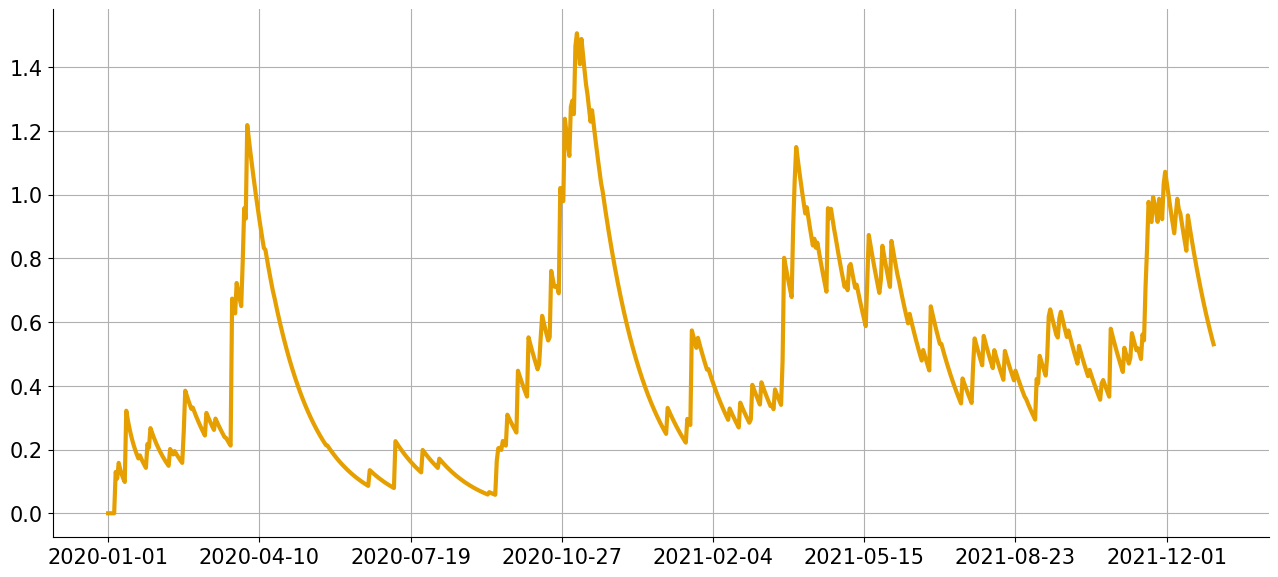

In [ ]:
fix,ax = plt.subplots()
ax.plot(covid_hospitalizations_per_day.index.get_level_values(0),covid_hospitalizations_per_day)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

#### States

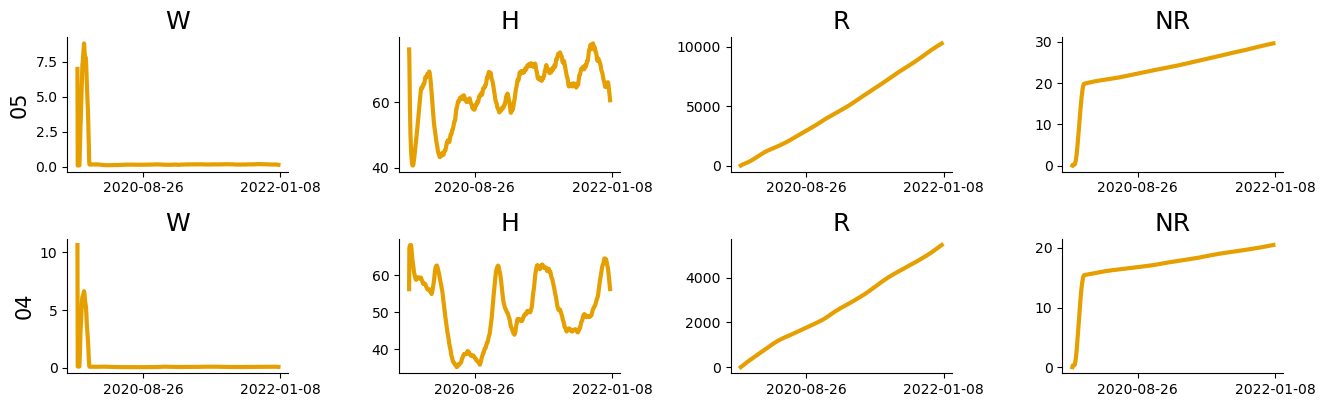

In [ ]:
fig, axs = plt.subplots(len(MDC_plot_classes),4)

for disease_idx, disease in enumerate(MDC_plot_classes):
    axs[disease_idx,0].set_ylabel(disease)
    for state_idx, state in enumerate(model.state_names):
        if disease=='04':
            out_plot = out.sel(MDC_keys=disease)[state]+out.sel(MDC_keys='covid')[state]
        else:
            out_plot = out.sel(MDC_keys=disease)[state].copy()
        axs[disease_idx,state_idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[disease_idx,state_idx].set_title(state)
        axs[disease_idx,state_idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[disease_idx,state_idx].grid(False)
        axs[disease_idx,state_idx].tick_params(axis='both', which='major', labelsize=10)
        axs[disease_idx,state_idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center',fontsize=8)
#plt.legend()
plt.show()

#### X-H

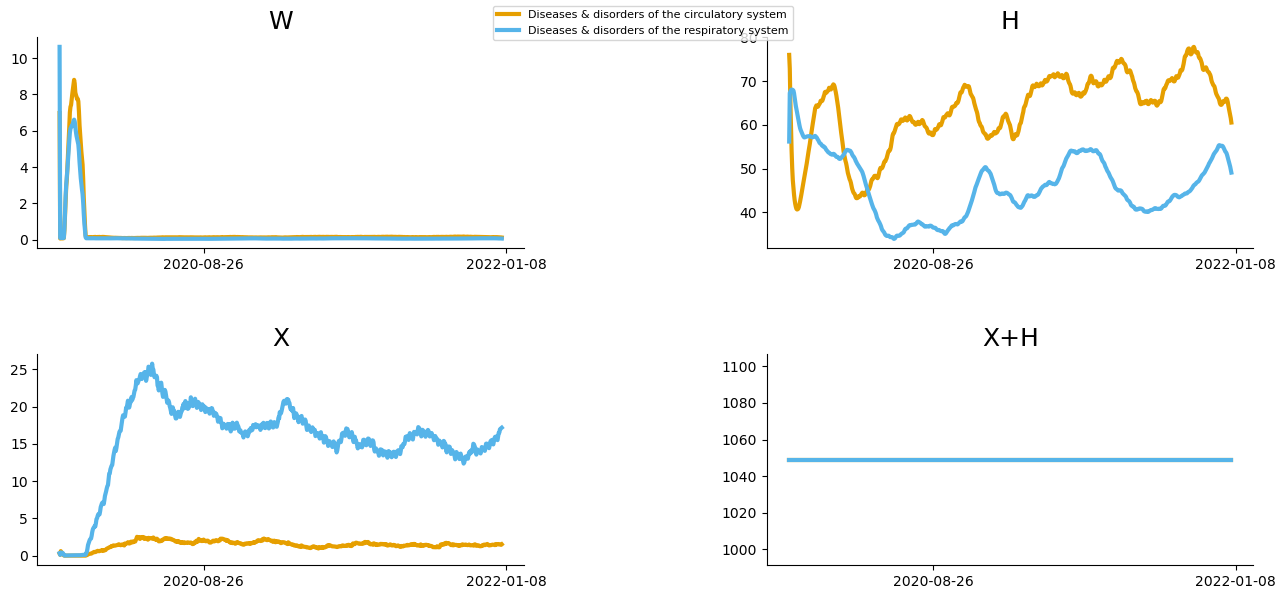

In [ ]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X']):
    for dis_idx, disease in enumerate(MDC_plot_classes):
        if state=='X':
            #out_plot = out.sel(MDC_keys=disease)['X']+out.sel(MDC_keys=disease)['H']
            out_plot = X[:,dis_idx]
        else:
            out_plot = out.sel(MDC_keys=disease)[state].copy()
        axs[idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,fontsize=8,loc='upper center')
plt.show()

#### sum

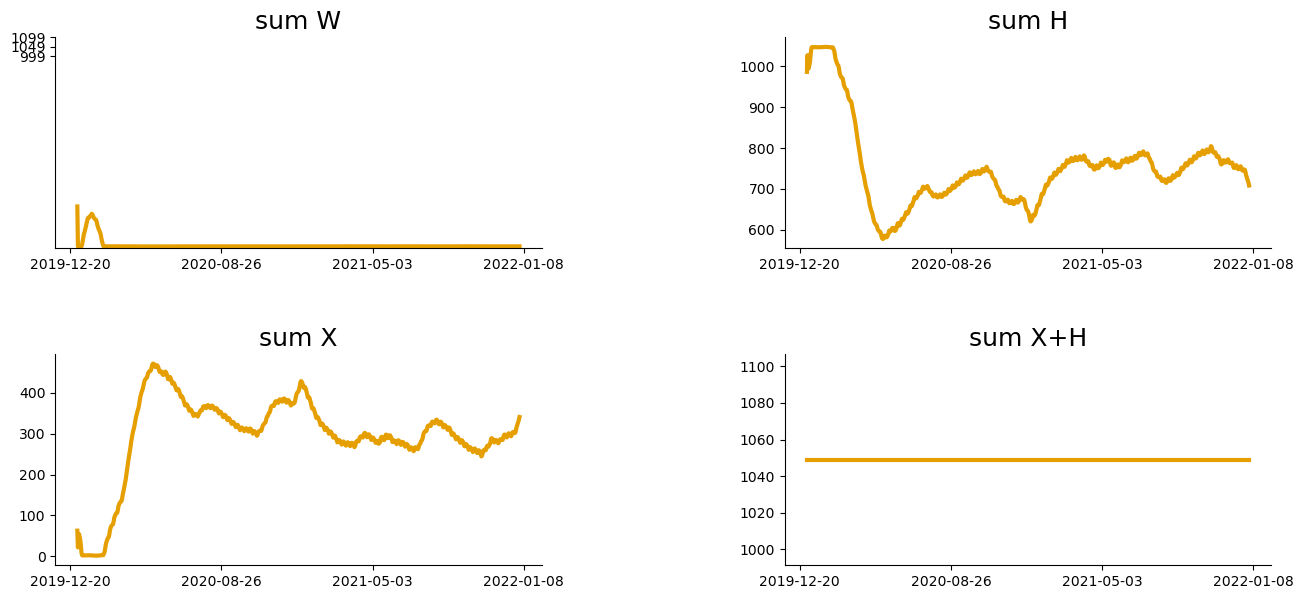

In [ ]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state=='X':
        #out_plot = out.sum('MDC_keys')['X']-out.sum('MDC_keys')['H']
        out_plot = np.sum(X,axis=1)
    elif state == 'X+H':
        out_plot = np.sum(X,axis=1) + out.sum('MDC_keys')['H']
    else:
        out_plot = out.sum('MDC_keys')[state]
    axs[idx].plot(time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
axs[0].set_yticks(ticks=[X_tot-50,X_tot,X_tot+50])
plt.show()


#### daily hospitalizations

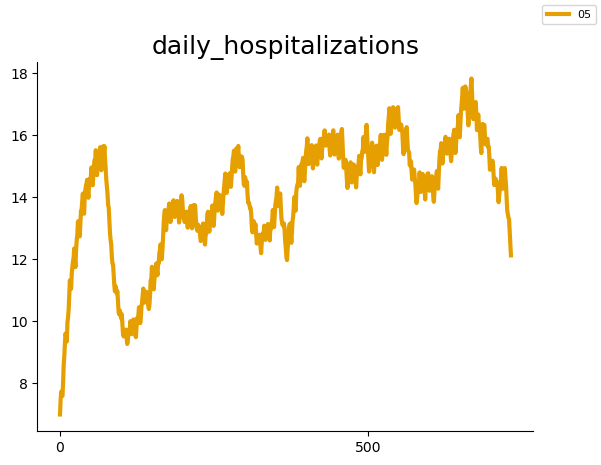

In [ ]:
fig, ax = plt.subplots()
ax.set_title('daily_hospitalizations')
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
for idx,disease in enumerate(['05']):
    ax.plot(range(len(hospitalizations_per_day_covid[disease])),hospitalizations_per_day_covid[disease], label=disease)
fig.legend(fontsize=8)
plt.show()

#### Normalized

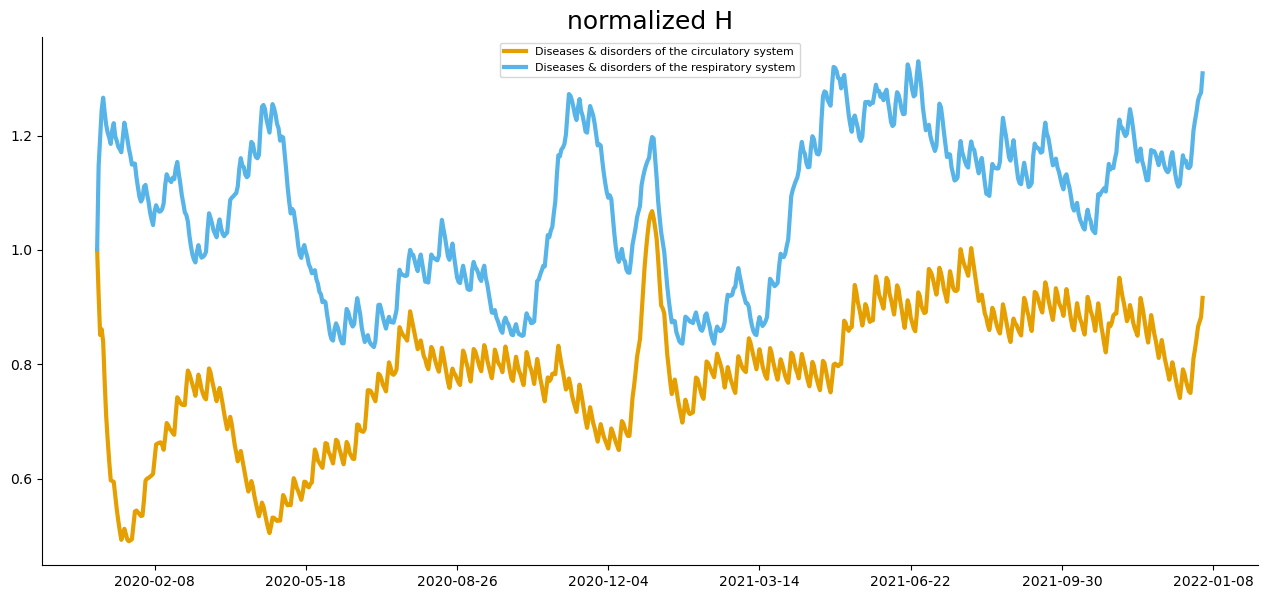

In [ ]:
fix,ax=plt.subplots()

for disease in MDC_plot_classes:
    if disease=='04':
        out_plot = out.sel(MDC_keys=disease)['H']+out.sel(MDC_keys='covid')['H'].values
    else:
        out_plot = out.sel(MDC_keys=disease)['H'].copy().values

    for idx, t in enumerate(time):
        week=t.isocalendar().week
        day=t.isocalendar().weekday
        out_plot[idx] = out_plot[idx]/hospitalization_baseline.loc[disease,week,day]
    out_plot = pd.DataFrame(out_plot).ewm(span=14).mean()
    ax.plot(time,out_plot, label=MDC_dict[disease])
    ax.set_title('normalized H')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

#### covid_H

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


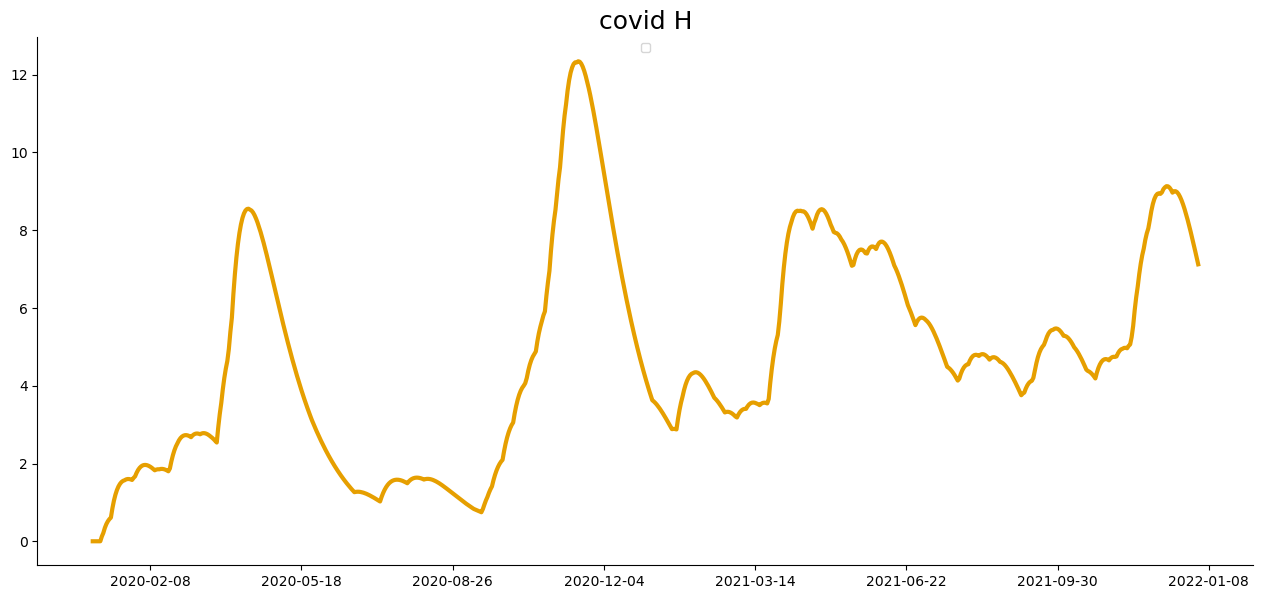

In [ ]:
fix,ax=plt.subplots()

ax.plot(time,out_real_world_covid.sel(MDC_keys='covid')['H'])
ax.set_title('covid H')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()